In [23]:
BUILD95 = True
BUILD96 = True

import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [24]:
%%time
# LOAD TRAIN
X_train = pd.read_csv('../Data/train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('../Data/train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv('../Data/test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('../Data/test_identity.csv',index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET/Label
y_train = X_train['isFraud'].copy()
del X_train['isFraud']
del train_id, test_id; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (506691, 213)
CPU times: user 19.3 s, sys: 633 ms, total: 19.9 s
Wall time: 20 s


NameError: name 'y_test' is not defined

In [26]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 

In [27]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (np.str(X_train[f].dtype)=='category')|(X_train[f].dtype=='object'): 
        df_comb = pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt','TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

CPU times: user 2.59 s, sys: 228 ms, total: 2.82 s
Wall time: 2.14 s


In [28]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES by underscore
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE count how many times a category repeats in a column
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

In [29]:
df = pd.DataFrame({'id': ['egg', 'egg', 'egg', 'egg',
                          'ham', 'ham','ham'],
                   'value1': [1, 0, 1, 1, 0, 0,1]})

df.groupby('id')['value1'].agg(['mean']).to_dict()

dict1 = {'egg': 0.75, 'ham': 0.3333333333333333}
s = pd.Series(['egg', 'ham',"egg"])
type(s.map(dict1))

pandas.core.series.Series

Code below creates new features.

In [30]:
%%time
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain','R_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE for new features
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , R_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: user 13.5 s, sys: 1.47 s, total: 14.9 s
Wall time: 14.9 s


We would like to feature the time of transaction because the fraud follows a pattern in a day: higher the morning and lower in the afternoon/evening. We will need to calculate the hour of a transaction for both training data and test data.

In [31]:
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
X_train["Date"] = X_train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

X_train['Weekdays'] = X_train['Date'].dt.dayofweek
X_train['Hours'] = X_train['Date'].dt.hour
X_train['Days'] = X_train['Date'].dt.day
X_train['Month'] = X_train['Date'].dt.month

In [32]:
X_test["Date"] = X_test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

X_test['Weekdays'] = X_test['Date'].dt.dayofweek
X_test['Hours'] = X_test['Date'].dt.hour
X_test['Days'] = X_test['Date'].dt.day
X_test['Month'] = X_test['Date'].dt.month

In [33]:
X_train['Hours']

TransactionID
2987000.0     0
2987001.0     0
2987002.0     0
2987003.0     0
2987004.0     0
             ..
3577535.0    23
3577536.0    23
3577537.0    23
3577538.0    23
3577539.0    23
Name: Hours, Length: 590540, dtype: int64

Next, we will use several different approaches for feature selection. The first one is time consistancy, which check whether a feature is good indicator over the time.

In [15]:
# #Define columns that we would like to test
# col = list( X_train.columns )
# col.remove('TransactionDT')
# for c in ['D6','D7','D8','D9','D12','D13','D14','isFraud','Date']:
#     col.remove(c)

    
# # SPLIT DATA INTO FIRST MONTH AND LAST MONTH
# train = X_train[X_train.Month==12].copy()
# validate = X_train[X_train.Month==6].copy()

# # TRAIN AND VALIDATE
# import lightgbm as lgb

# lgbm = lgb.LGBMClassifier(n_estimators=500, objective='binary', 
#         num_leaves=8, learning_rate=0.02)

# #Create an empty dataframe
# feature_auc_score = pd.DataFrame(columns = ['feature','train_score','test_score'])

# #Looping through col to get train and test scores
# for i in col:
#     h = lgbm.fit(train[[i]], train.isFraud, eval_metric='auc', 
#             eval_set=[(train[[i]],train.isFraud),(validate[[i]],validate.isFraud)])
#     auc_train = np.round(h._best_score['valid_0']['auc'],4)
#     auc_val = np.round(h._best_score['valid_1']['auc'],4)
#     feature_auc_score = feature_auc_score.append([{'feature':i,'train_score':auc_train,'test_score':auc_val}])

In [34]:
#Load the dataframe for time consistance test results
feature_auc_score = pd.read_csv('time_continuity_feature_score.csv')

In [49]:
#Return the results for feature that does not pass time consistancy test. 
#The threshold is set at 0.5 because this is a flipping coin probability.
feature_auc_score[feature_auc_score['test_score'] <= 0.5]
failed_feature = list(feature_auc_score[feature_auc_score['test_score'] <= 0.5]['feature'])

In [50]:
failed_feature

['card4',
 'M5',
 'V14',
 'V20',
 'V23',
 'V26',
 'V27',
 'V41',
 'V56',
 'V65',
 'V67',
 'V68',
 'V78',
 'V88',
 'V89',
 'V107',
 'V117',
 'V120',
 'V121',
 'V136',
 'V138',
 'V142',
 'V160',
 'V162',
 'V165',
 'V274',
 'V285',
 'V286',
 'V289',
 'V305',
 'V310',
 'id_08',
 'id_14',
 'id_23',
 'id_24',
 'id_27',
 'id_30',
 'id_32',
 'id_33',
 'id_34',
 'id_38',
 'Weekdays',
 'Days',
 'Month']

In [51]:
print(X_train.columns.values)

['TransactionDT' 'TransactionAmt' 'ProductCD' 'card1' 'card2' 'card3'
 'card4' 'card5' 'card6' 'addr1' 'addr2' 'dist1' 'dist2' 'P_emaildomain'
 'R_emaildomain' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9' 'C10' 'C11'
 'C12' 'C13' 'C14' 'D1' 'D2' 'D3' 'D4' 'D5' 'D6' 'D7' 'D8' 'D9' 'D10'
 'D11' 'D12' 'D13' 'D14' 'D15' 'M1' 'M2' 'M3' 'M4' 'M5' 'M6' 'M7' 'M8'
 'M9' 'V1' 'V3' 'V4' 'V6' 'V8' 'V11' 'V13' 'V14' 'V17' 'V20' 'V23' 'V26'
 'V27' 'V30' 'V36' 'V37' 'V40' 'V41' 'V44' 'V47' 'V48' 'V54' 'V56' 'V59'
 'V62' 'V65' 'V67' 'V68' 'V70' 'V76' 'V78' 'V80' 'V82' 'V86' 'V88' 'V89'
 'V91' 'V107' 'V108' 'V111' 'V115' 'V117' 'V120' 'V121' 'V123' 'V124'
 'V127' 'V129' 'V130' 'V136' 'V138' 'V139' 'V142' 'V147' 'V156' 'V160'
 'V162' 'V165' 'V166' 'V169' 'V171' 'V173' 'V175' 'V176' 'V178' 'V180'
 'V182' 'V185' 'V187' 'V188' 'V198' 'V203' 'V205' 'V207' 'V209' 'V210'
 'V215' 'V218' 'V220' 'V221' 'V223' 'V224' 'V226' 'V228' 'V229' 'V234'
 'V235' 'V238' 'V240' 'V250' 'V252' 'V253' 'V257' 'V258' 'V260' 'V261

In [61]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in failed_feature:
    cols.remove(c)
for c in ['Date']:
    cols.remove(c)  


In [65]:
pca_col = [col for col in cols if col.startswith('V')]
pca_col

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V17',
 'V30',
 'V36',
 'V37',
 'V40',
 'V44',
 'V47',
 'V48',
 'V54',
 'V59',
 'V62',
 'V70',
 'V76',
 'V80',
 'V82',
 'V86',
 'V91',
 'V108',
 'V111',
 'V115',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V139',
 'V147',
 'V156',
 'V166',
 'V169',
 'V171',
 'V173',
 'V175',
 'V176',
 'V178',
 'V180',
 'V182',
 'V185',
 'V187',
 'V188',
 'V198',
 'V203',
 'V205',
 'V207',
 'V209',
 'V210',
 'V215',
 'V218',
 'V220',
 'V221',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V234',
 'V235',
 'V238',
 'V240',
 'V250',
 'V252',
 'V253',
 'V257',
 'V258',
 'V260',
 'V261',
 'V264',
 'V266',
 'V267',
 'V271',
 'V277',
 'V281',
 'V283',
 'V284',
 'V291',
 'V294',
 'V296',
 'V297',
 'V301',
 'V303',
 'V307',
 'V309',
 'V314',
 'V320']

In [66]:
X_train[pca_col]

,V1,V3,V4,V6,V8,V11,V13,V17,V30,V36,...,V291,V294,V296,V297,V301,V303,V307,V309,V314,V320
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,-1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,117.000000,0.0,0.000000,0.000000
2987001.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
2987002.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
2987003.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,0.0,0.0,1.0,...,0.0,38.0,0.0,0.0,0.0,0.0,1758.000000,0.0,0.000000,0.000000
2987004.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577535.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,47.950001,0.0,47.950001,0.000000
3577536.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
3577537.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [173]:
from sklearn.model_selection import train_test_split
# test_size: what proportion of original data is used for test set
train_feature, test_feature, train_lbl, test_lbl = train_test_split(X_train, y_train, test_size=1/7.0, random_state=0)

In [174]:
train_feature

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,D11_card1_std,D11_card1_addr1_mean,D11_card1_addr1_std,D11_card1_addr1_P_emaildomain_mean,D11_card1_addr1_P_emaildomain_std,Date,Weekdays,Hours,Days,Month
TransactionID,,,,,,,,,,,,,,,,,,,,,
3083628.0,1971676.0,50.000000,1,6585.0,453.0,50.0,3,126.0,1,104.0,...,227.526657,391.306824,244.653305,335.228729,218.587265,2017-12-23 19:41:16,5,19,23,12
3060528.0,1629734.0,59.000000,4,11538.0,443.0,50.0,2,124.0,2,287.0,...,197.019760,243.201416,153.063370,377.136597,-1.000000,2017-12-19 20:42:14,1,20,19,12
3106598.0,2330538.0,161.783005,0,2867.0,196.0,85.0,3,126.0,1,-1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2017-12-27 23:22:18,2,23,27,12
3373711.0,9683761.0,49.000000,4,13290.0,412.0,50.0,3,126.0,2,125.0,...,220.195877,358.497192,183.873383,343.438995,188.287109,2018-03-23 01:56:01,4,1,23,3
3059901.0,1624002.0,171.000000,4,3436.0,74.0,50.0,3,126.0,2,341.0,...,237.168152,397.840637,241.385178,306.158936,205.805710,2017-12-19 19:06:42,1,19,19,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346783.0,8906146.0,97.000000,4,17018.0,352.0,50.0,2,17.0,2,164.0,...,226.207275,366.053162,227.414062,356.038544,223.072906,2018-03-14 01:55:46,2,1,14,3
3139315.0,3162019.0,261.950012,4,7436.0,115.0,50.0,3,126.0,1,91.0,...,189.954605,392.845642,165.284698,505.718658,228.175873,2018-01-06 14:20:19,5,14,6,1
3104952.0,2307868.0,76.023003,0,13037.0,11.0,50.0,3,126.0,1,-1.0,...,246.986862,-1.000000,-1.000000,-1.000000,-1.000000,2017-12-27 17:04:28,2,17,27,12


In [175]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(train_feature[pca_col])
# Apply transform to both the training set and the test set.
train_feature[pca_col] = scaler.transform(train_feature[pca_col])
test_feature[pca_col] = scaler.transform(test_feature[pca_col])

/Users/longhaochen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/longhaochen/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/longhaochen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [176]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.95)

In [177]:
pca.fit(train_feature[pca_col])

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [178]:
pc_names = []
for i in range(1,37):
    pc_names.append('PC' + str(i))
    
#Perform PCA conversion to both train and test dataframes
train_pca_df = pd.DataFrame(pca.transform(train_feature[pca_col]),columns=pc_names)
test_pca_df = pd.DataFrame(pca.transform(test_feature[pca_col]),columns=pc_names)


In [179]:
#Merge the PCS transformed columns with train_feature and test_feature
train_feature = pd.concat([train_feature.reset_index(drop=True), train_pca_df], axis=1)
test_feature = pd.concat([test_feature.reset_index(drop=True), test_pca_df], axis=1)

In [181]:
print(pca.n_components_)

36


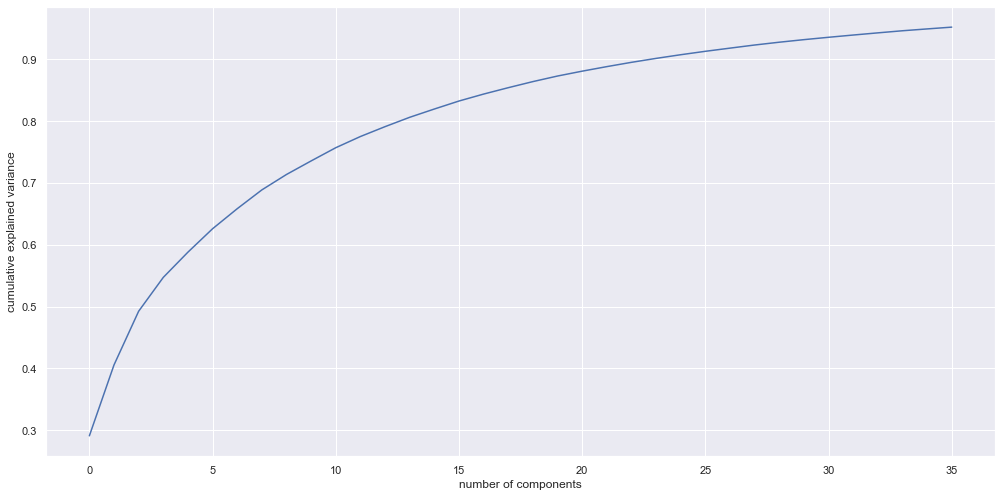

In [182]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

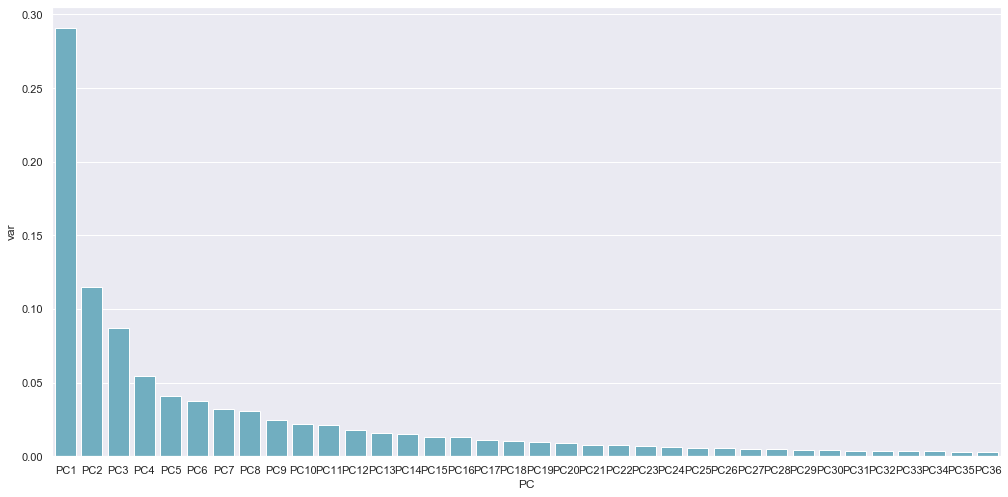

In [183]:
import seaborn as sns

df_plot = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':pc_names})
sns.set(rc={'figure.figsize':(17,8.27)})
sns.barplot(x='PC',y="var", 
           data=df_plot, color="c");

In [109]:
train_feature

array([[ 6.941262  , -2.6414354 , -4.9964275 , ...,  1.0571749 ,
         0.3429212 , -0.6567632 ],
       [-1.90082   , -0.17071752, -2.8677716 , ...,  0.16831233,
         0.02105878, -0.07986759],
       [ 4.9508157 , -0.9213842 ,  7.836923  , ...,  0.63384783,
         0.11414281, -0.13086593],
       ...,
       [ 7.1620684 , -0.2608849 ,  6.81219   , ...,  0.8089345 ,
         0.8292053 ,  0.03179431],
       [-3.2397404 ,  0.13085367,  0.15802151, ..., -0.081861  ,
        -0.14542899,  0.0452936 ],
       [-1.9660795 ,  0.1652972 ,  0.6130914 , ...,  0.23991443,
        -0.1438528 , -0.26612028]], dtype=float32)